In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

In [3]:
from scipy import linalg
import matplotlib.pyplot as plt

In [4]:
from timeit import default_timer as timer

In [5]:
TOLERANCE = 1.0e-10

In [6]:
def lu_solve(A, b):
    lu, piv = linalg.lu_factor(A)
    x = linalg.lu_solve((lu, piv), b)
    return x

In [7]:
def gs_solve(A, b, n_iter=1000, verbose=False):
    if verbose:
        print('-' * 10)
        print('Gauss Seidel solver')
        print('-' * 10)
        
    nrows, ncols = A.shape
    x = np.zeros_like(b)
    x_new = np.zeros_like(b)

    if A.shape[0] != b.shape[0]:
        raise ValueError('A and b have different number of rows')

    for k in range(n_iter):
        for i in range(nrows):
            x_new[i] = b[i] / A[i, i]
            if verbose and k % 250 == 0:
                print('-' * 10)
                print(f'iter: {k}')
                print(f'b[{i}] = {b[i]}, A[{i}, {i}] = {A[i, i]}, quot = {b[i] / A[i, i]}')
            for j in range(nrows):
                if i != j:
                    if verbose and k % 250 == 0:
                        print(f'A[{i}, {j}] = {A[i, j]}, A[{i}, {i}] = {A[i, i]}, quot = {A[i, j] / A[i, i]}')
                        print(f'x[{j}] = {x[j]}')
                    x_new[i] = x_new[i] - ((A[i, j] / A[i, i]) * x[j])
                    x[i] = x_new[i]

    return x

In [8]:
def cg_solve(A, b, tol=TOLERANCE, verbose=False):
    if verbose:
        print('-' * 10)
        print('Conjugate gradient solver')
        print('-' * 10)
        print(f'cond(A) = {np.linalg.cond(A)}')
    
    EPSILON = 1.0e-10
    
    if np.trace(A)< 0:
        raise ValueError('A is not positive semi-definite!')
    
    nrows, ncols = A.shape
    
    x = np.zeros_like(b)
    r = b.copy()
    r_old = np.zeros_like(b)
    p = r.copy()
    Ap = np.zeros_like(b)
    
    for i in range(nrows):
        Ap = A.dot(p)

        alpha = np.dot(r, r) / max(np.dot(p, Ap), EPSILON)
        if verbose:
            print('-' * 10)
            print(f'coord: x{i}')
            print(f'rTr = {np.dot(r, r)}, pTAp = {np.dot(p, Ap)}, quot = {alpha}')
            
        x = x + alpha * p
        r = r - alpha * Ap
        
        if np.linalg.norm(r, 2) < tol:
            print('CG concverged. Exiting...')
            break
        
        beta = np.dot(r, r) / max(np.dot(r_old, r_old), EPSILON)
        if verbose:
            print(f'rTr = {np.dot(r, r)}, roTro = {np.dot(r_old, r_old)}, quot = {beta}')
            
        p = r + beta * p
        r_old = r
    
    return x

In [27]:
def cg_solve_scipy(A, b, tol=TOLERANCE):
    from scipy.sparse.linalg import cg
    x, info = cg(A, b, tol=TOLERANCE)
    if info != 0:
        print(f'Failed to solve! Info = {info}')
    return x

In [10]:
def cg_solve_preconditioned(A, b, p, tol=TOLERANCE):
    pass    

In [28]:
def test_solvers(A, b, verbose=False):
    start = timer()
    x_lu = lu_solve(A, b)
    stop = timer()
    print(f'LU:\t\t{stop-start:.0e} s')
    start = timer()
    x_gs = gs_solve(A, b)
    stop = timer()
    print(f'GS:\t\t{stop-start:.0e} s')
    start = timer()
    x_cg = cg_solve_scipy(A, b)
    stop = timer()
    print(f'CG:\t\t{stop-start:.0e} s')
    return x_lu, x_gs, x_cg

In [12]:
def test_on_spline(i):
    A = np.loadtxt(f'matrix_examples/A{i}.txt', delimiter=', ')
    b = np.loadtxt(f'matrix_examples/b{i}.txt', delimiter=', ')
    x_true = np.loadtxt(f'matrix_examples/x{i}.txt', delimiter=', ')

    plt.figure()
    im = plt.imshow(A, cmap='hot')
    plt.colorbar(im)

    x_lu, x_gs, x_cg = test_solvers(A, b)
        
    plt.figure()
    plt.plot(x_true, x_lu, 'k.')
    plt.xlabel('tpsdemo LU solution')
    plt.ylabel('scipy.linalg.lu_solve')

    fig, ax = plt.subplots(4, 1)
    idx = np.arange(0, len(x_lu))

    ax[0].plot(idx, x_true, 'k.')
    ax[0].set_ylabel('LU\n(tpsdemo)')
    _ = ax[0].set_xticks(idx)
    ax[0].set_xticklabels([])

    ax[1].plot(idx, x_lu, 'k.')
    ax[1].set_ylabel('LU\n(scipy)')
    _ = ax[1].set_xticks(idx)
    ax[1].set_xticklabels([])

    ax[2].plot(idx, x_gs, 'k.')
    ax[2].set_ylabel('GS')
    _ = ax[2].set_xticks(idx)
    ax[2].set_xticklabels([])

    ax[3].plot(idx, x_cg, 'k.')
    ax[3].set_ylabel('CG\n(scipy)')
    _ = ax[3].set_xticks(idx)

    plt.show()

## Example: 2 x 2, integer coefficients

In [29]:
A = np.array([[4, 1], [1, 3]], dtype=float)
b = np.array([1, 2], dtype=float)

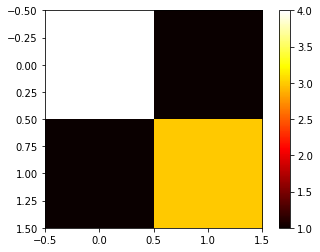

In [30]:
im = plt.imshow(A, cmap='hot')
plt.colorbar(im)

In [31]:
x_lu, x_gs, x_cg = test_solvers(A, b)

LU:		2e-04 s
GS:		4e-03 s
CG:		4e-04 s


Text(0, 0.5, 'CG solution')

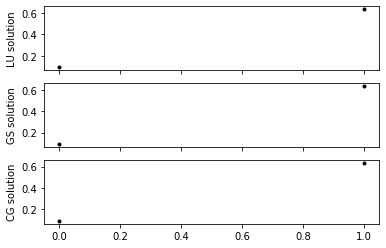

In [32]:
fig, ax = plt.subplots(3, 1)

idx = np.arange(len(x_lu))
ax[0].plot(idx, x_lu, 'k.')
ax[0].set_ylabel('LU solution')
ax[0].set_xticklabels([])

ax[1].plot(idx, x_gs, 'k.')
ax[1].set_ylabel('GS solution')
ax[1].set_xticklabels([])

ax[2].plot(idx, x_cg, 'k.')
ax[2].set_ylabel('CG solution')

## Example: first spline matrix

In [33]:
A = np.loadtxt(f'matrix_examples/A0.txt', delimiter=', ')
b = np.loadtxt(f'matrix_examples/b0.txt', delimiter=', ')
x_true = np.loadtxt(f'matrix_examples/x0.txt', delimiter=', ')

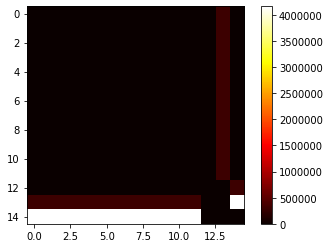

In [34]:
plt.figure()
im = plt.imshow(A, cmap='hot')
plt.colorbar(im)

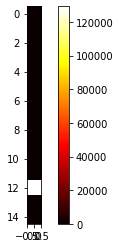

In [35]:
plt.figure()
im = plt.imshow(x_true.reshape((x_true.shape[0], 1)), cmap='hot')
plt.colorbar(im)

In [36]:
x_lu, x_gs, x_cg = test_solvers(A, b, verbose=True)

LU:		3e-04 s
GS:		6e-01 s
Failed to solve! Info = 150
CG:		5e-03 s


In [39]:
from scipy.sparse.linalg import gmres
start = timer()
x_gmres, info = gmres(A, b, tol=TOLERANCE)
stop = timer()
print(f'GMRES:\t\t{stop-start:.0e} s')

GMRES:		2e-03 s


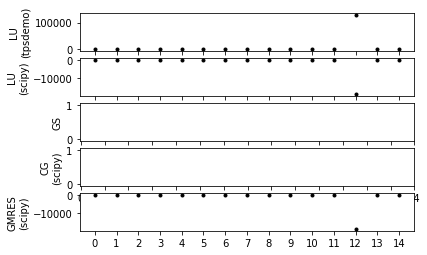

In [40]:
fig, ax = plt.subplots(5, 1)
idx = np.arange(0, len(x_lu))

ax[0].plot(idx, x_true, 'k.')
ax[0].set_ylabel('LU\n(tpsdemo)')
_ = ax[0].set_xticks(idx)
ax[0].set_xticklabels([])

ax[1].plot(idx, x_lu, 'k.')
ax[1].set_ylabel('LU\n(scipy)')
_ = ax[1].set_xticks(idx)
ax[1].set_xticklabels([])

ax[2].plot(idx, x_gs, 'k.')
ax[2].set_ylabel('GS')
_ = ax[2].set_xticks(idx)
ax[2].set_xticklabels([])

ax[3].plot(idx, x_cg, 'k.')
ax[3].set_ylabel('CG\n(scipy)')
_ = ax[3].set_xticks(idx)

ax[4].plot(idx, x_gmres, 'k.')
ax[4].set_ylabel('GMRES\n(scipy)')
_ = ax[4].set_xticks(idx)

## Examples: spline matrix

LU:		1e-04 s
GS:		6e-01 s
Failed to solve! Info = 150
CG:		9e-03 s


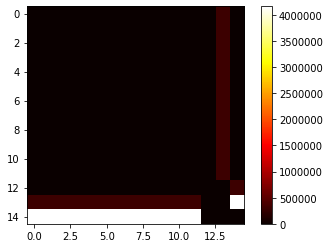

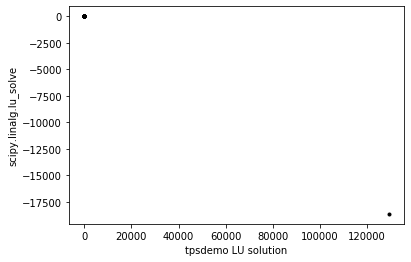

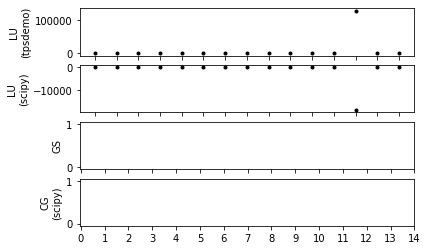

In [23]:
test_on_spline(0)

In [24]:
info

0

In [25]:
print(np.linalg.cond(A))

14182000944706.055


In [43]:
Ainv = linalg.inv(A)
x_true = Ainv.dot(b)

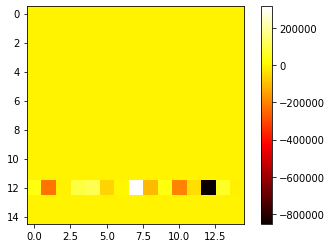

In [42]:
plt.figure()
im = plt.imshow(Ainv, cmap='hot')
plt.colorbar(im)

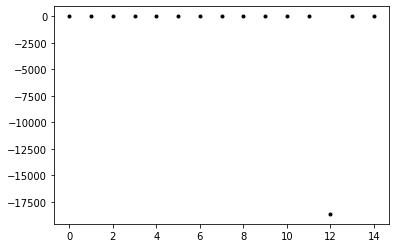

In [44]:
plt.plot(np.arange(len(x_true)), x_true, 'k.')

In [45]:
from scipy.sparse import issparse
issparse(A)

False

In [46]:
np.sum(A != 0) / np.prod(A.shape)

0.92